
# Modelo de Classificação de escolas baseada em dados do INEP (2014-2023)

## Bibliotecas

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
import warnings
import pycountry
import matplotlib.pyplot as plt
import geopandas as gpd


# Suprimir todos os warnings
warnings.filterwarnings("ignore")



## Importação dos Dados

In [54]:
# Download latest version
path = "./dataset/master.csv"

# Carregar o arquivo CSV no DataFrame
df = pd.read_csv(path)


## Análise Exploratória de Dados

In [55]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [56]:
# Remover coluna country-year por motivos de redundância
df = df.drop(columns=["country-year"])

# renomear Colunas
df.rename(columns={"suicides/100k pop":"suicides_pop","HDI for year":"HDI_for_year",
                  " gdp_for_year ($) ":"gdp_for_year"," gdp_per_capita ($) ":"gdp_per_capita",
                    "gdp_per_capita ($)":"gdp_per_capita"}, inplace=True)

# Alterar colunas
df["gdp_for_year"] = df["gdp_for_year"].str.replace(",","").astype(np.int64)
df["age"] = df["age"].str.replace("5-14 years","05-14 years")

In [57]:
antes = len(df)

# Removendo Duplicatas
df.drop_duplicates(ignore_index=True,inplace=True)

depois = len(df)

print(f"Linhas duplicadas existentes e removidas = {depois - antes}")

Linhas duplicadas existentes e removidas = 0


- Informações sobre Dataframe

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         27820 non-null  object 
 1   year            27820 non-null  int64  
 2   sex             27820 non-null  object 
 3   age             27820 non-null  object 
 4   suicides_no     27820 non-null  int64  
 5   population      27820 non-null  int64  
 6   suicides_pop    27820 non-null  float64
 7   HDI_for_year    8364 non-null   float64
 8   gdp_for_year    27820 non-null  int64  
 9   gdp_per_capita  27820 non-null  int64  
 10  generation      27820 non-null  object 
dtypes: float64(2), int64(5), object(4)
memory usage: 2.3+ MB


- Estatística Básica

In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,27820.0,2.001258e+03,8.469055e+00,1.985000e+03,1.995000e+03,2.002000e+03,2.008000e+03,2.016000e+03
suicides_no,27820.0,2.425744e+02,9.020479e+02,0.000000e+00,3.000000e+00,2.500000e+01,1.310000e+02,2.233800e+04
population,27820.0,1.844794e+06,3.911779e+06,2.780000e+02,9.749850e+04,4.301500e+05,1.486143e+06,4.380521e+07
suicides_pop,27820.0,1.281610e+01,1.896151e+01,0.000000e+00,9.200000e-01,5.990000e+00,1.662000e+01,2.249700e+02
HDI_for_year,8364.0,7.766011e-01,9.336671e-02,4.830000e-01,7.130000e-01,7.790000e-01,8.550000e-01,9.440000e-01
gdp_for_year,27820.0,4.455810e+11,1.453610e+12,4.691962e+07,8.985353e+09,4.811469e+10,2.602024e+11,1.812071e+13
gdp_per_capita,27820.0,1.686646e+04,1.888758e+04,2.510000e+02,3.447000e+03,9.372000e+03,2.487400e+04,1.263520e+05


- Contando Nulos ou NaN

In [60]:
df.isnull().sum()

country               0
year                  0
sex                   0
age                   0
suicides_no           0
population            0
suicides_pop          0
HDI_for_year      19456
gdp_for_year          0
gdp_per_capita        0
generation            0
dtype: int64

- Preencher os dados nulos com informações da ONU

In [76]:
hdr = pd.read_csv('./dataset/HDR.csv', encoding='latin1')

# Deletar Colunas que não servem
hdr_dropped = hdr.drop(columns=['hdicode','region','hdi_rank_2022','iso3'])

# Deletar Anos que Já estão preenchidos no dataset original
hdr_final = hdr_dropped.drop(hdr_dropped.columns[34:],axis=1)


# Alterar o padrão dos nomes das colunas
hdr_final.columns = hdr_final.columns.str.replace('hdi_','',regex=False)
hdr_final.reset_index()

# Reogarnizando o dataframe
hdr_final_melted = hdr_final.melt(id_vars='country',var_name='year',value_name='HDI_for_year')
hdr_final_melted['year'] = hdr_final_melted['year'].astype(int)

# Aplicar merge entre dataframes
merged_df = df.merge(hdr_final_melted,on=['country', 'year'],how='left')

df['HDI_for_year'] = merged_df['HDI_for_year_x'].combine_first(merged_df['HDI_for_year_y'])

In [83]:
df.isnull().sum()

country              0
year                 0
sex                  0
age                  0
suicides_no          0
population           0
suicides_pop         0
HDI_for_year      4632
gdp_for_year         0
gdp_per_capita       0
generation           0
dtype: int64

Com isso reduzimos o número de valores nulos de 19456 para 4954


### Boxplot

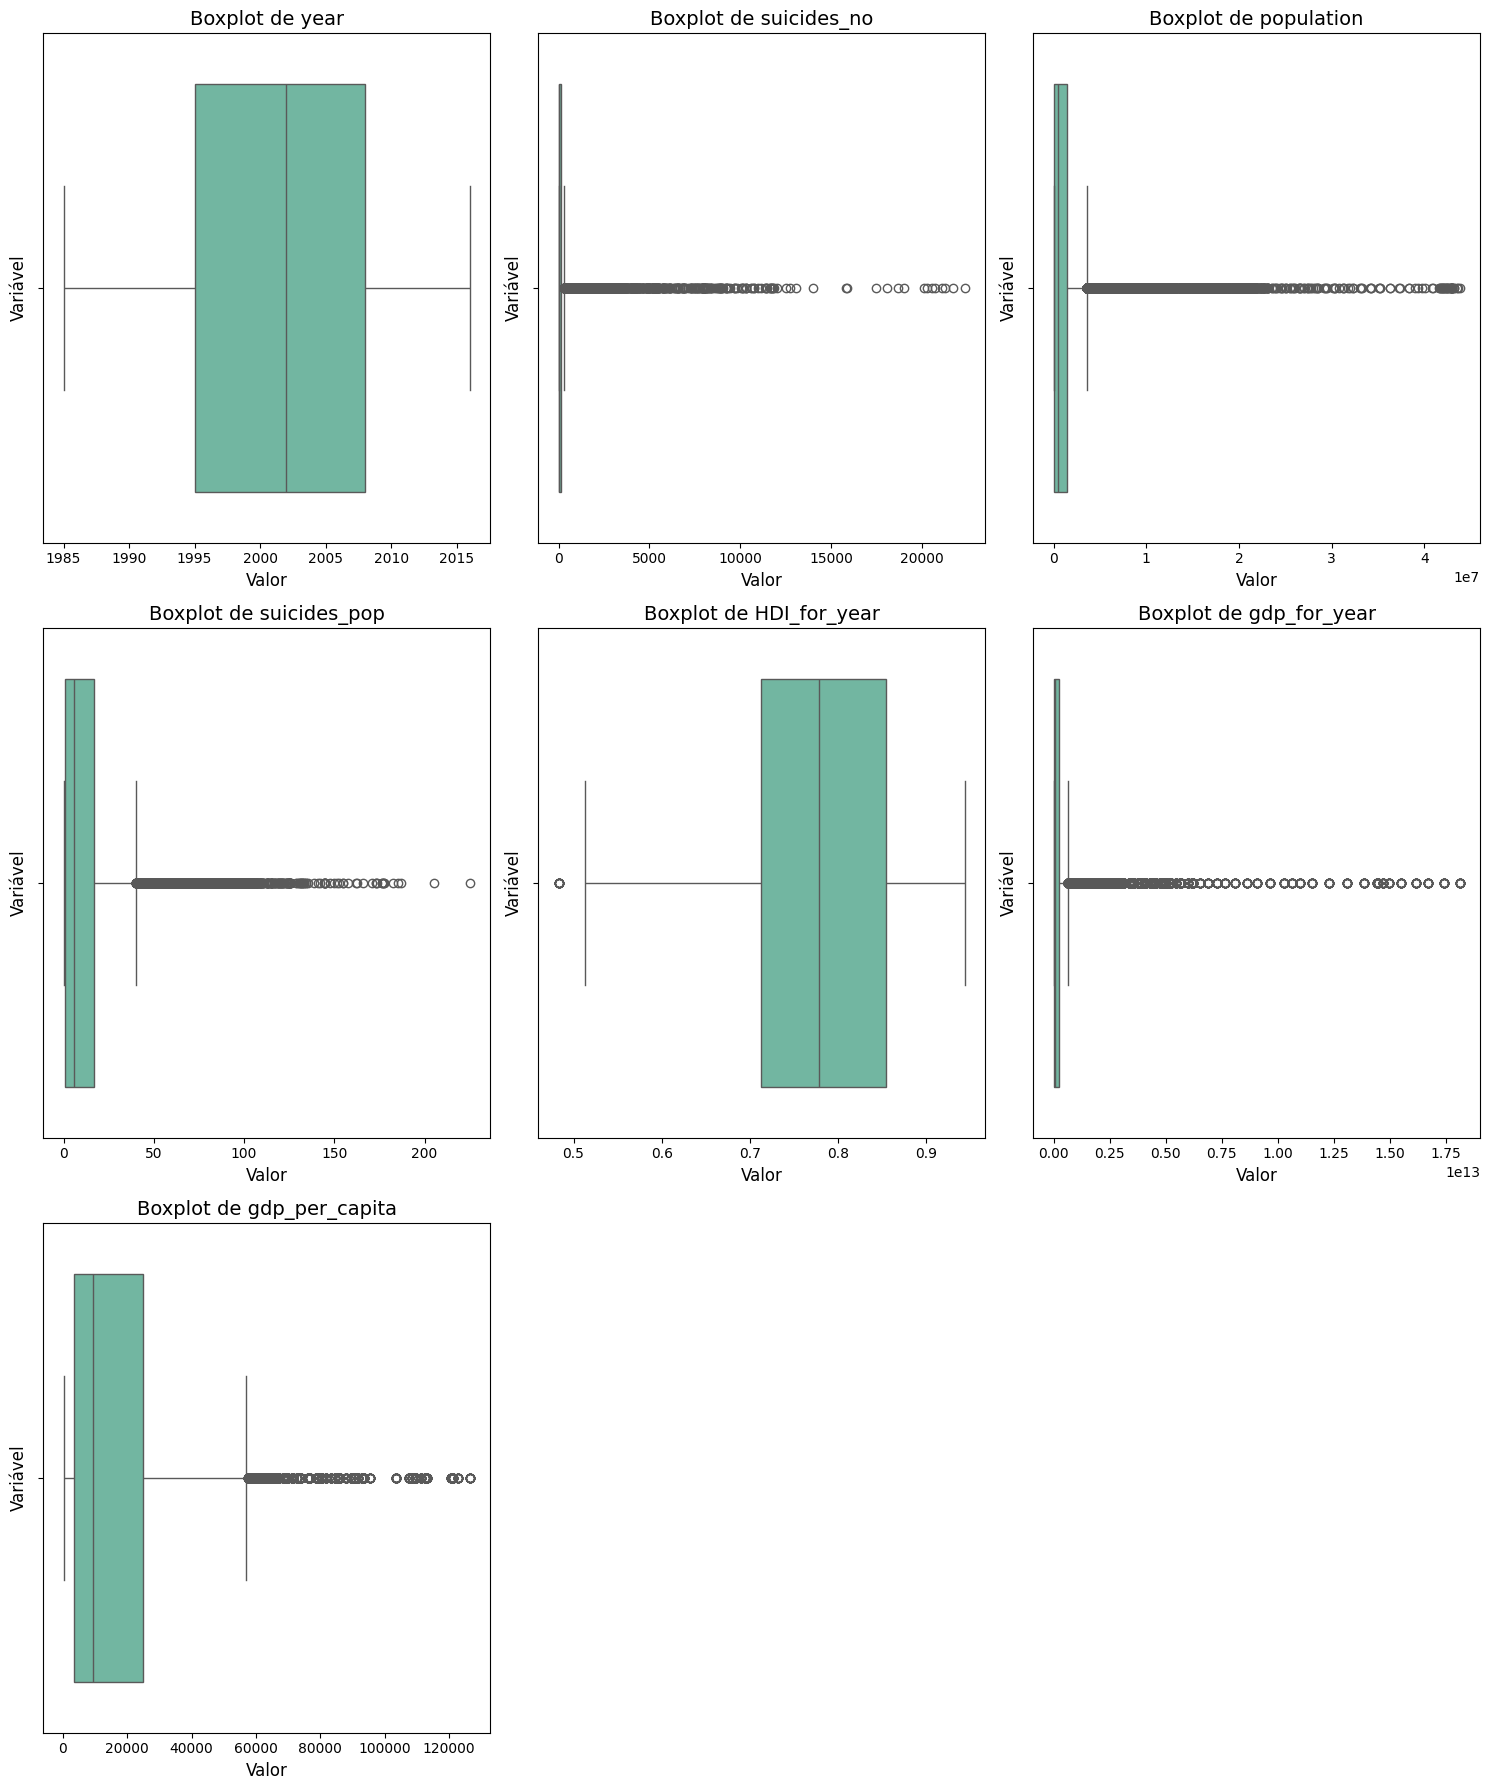

In [62]:
# Seleciona as colunas numéricas
df_numerical = df.select_dtypes(include=['number'])

# Lista das colunas numéricas
numeric_columns = df_numerical.columns

# Número de colunas e linhas com base nas variáveis numéricas
ncols = 3
nrows = int(np.ceil(len(numeric_columns) / ncols))

# Criando a figura com o número de subplots exato
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6 * nrows))

# Achatar os eixos para facilitar iteração
axes = axes.flatten()

# Criar um boxplot para cada coluna numérica
for i, col in enumerate(numeric_columns):
    sns.boxplot(data=df_numerical, x=col, ax=axes[i], palette="Set2")
    axes[i].set_title(f'Boxplot de {col}', fontsize=14)
    axes[i].set_xlabel('Valor', fontsize=12)
    axes[i].set_ylabel('Variável', fontsize=12)

# Remover subplots vazios se o número de colunas for menor que o número de subplots
for i in range(len(numeric_columns), len(axes)):
    axes[i].axis('off')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()


### Correlação

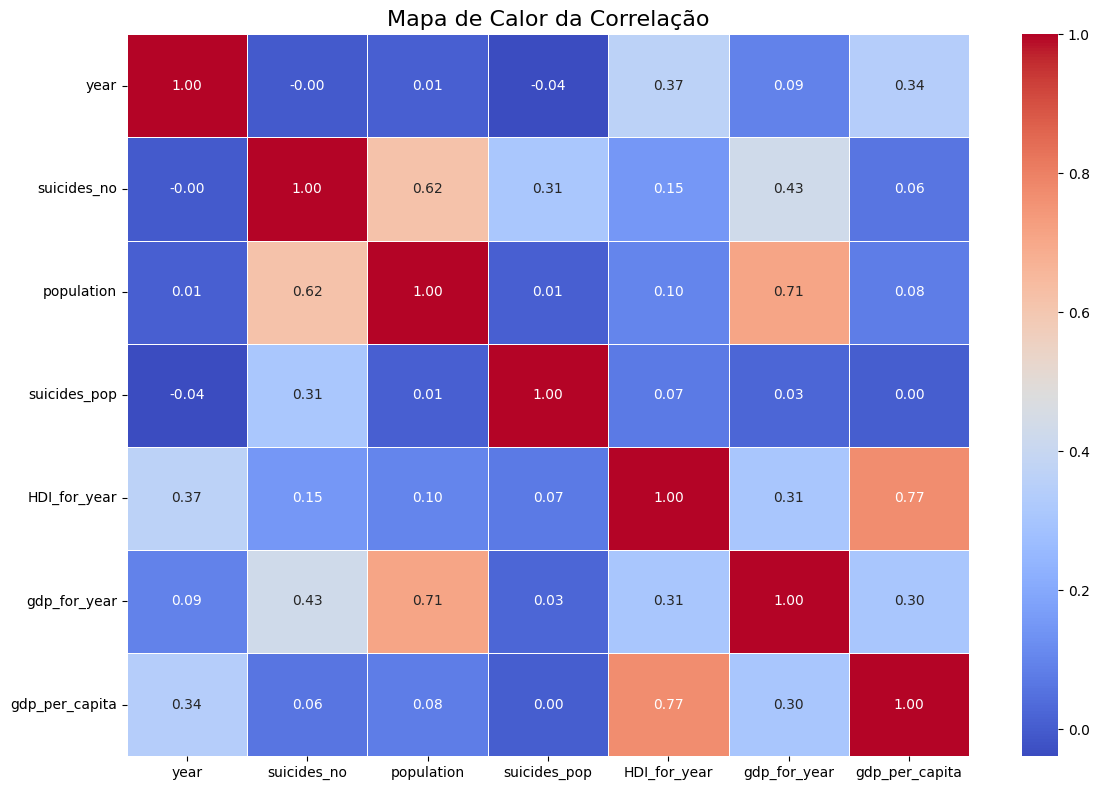

In [63]:
# Mapa de calor de correlação
# Calculando a matriz de correlação
correlation_matrix = df_numerical.corr()

# Plotando o mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Calor da Correlação', fontsize=16)
plt.tight_layout()
plt.show()


### Número de Suicídios por Gênero

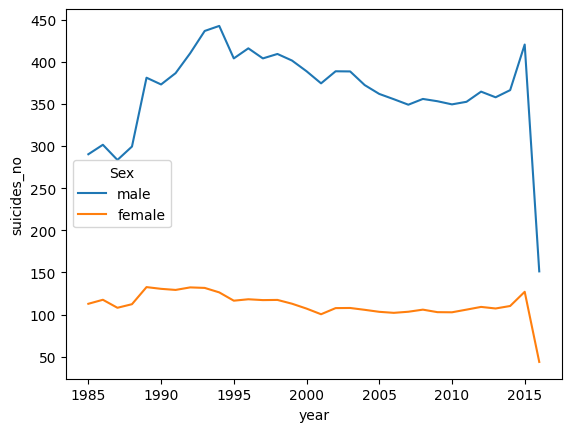

In [64]:
sns.lineplot(data=df, x='year', y='suicides_no', hue='sex', ci=None)
plt.legend(title='Sex')  # Título para a legenda
plt.show()



### Número de Suicídios por Faixa Etária

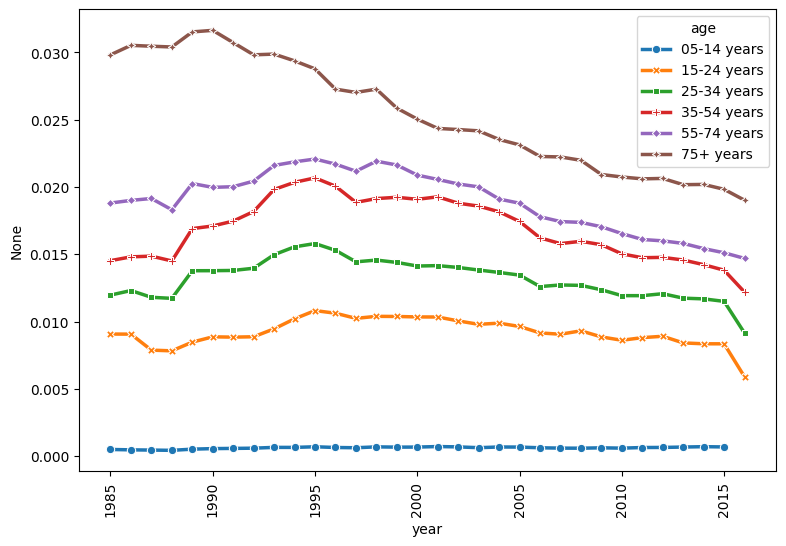

In [65]:
# Agrupar por Ano e Faixa Etária
df_age = df.groupby(["year", "age"])[["suicides_no", "population"]].sum()

# Resetar o índice
df_reset = df_age.reset_index()

# Criar o gráfico
plt.figure(figsize=(9, 6))
sns.lineplot(
    x="year", 
    y=df_reset["suicides_no"] * 100 / df_reset["population"], 
    hue="age",
    data=df_reset, 
    linewidth=2.5, 
    style="age", 
    markers=True, 
    dashes=False
)
plt.xticks(rotation=90)
plt.show()



### Número de Suicídios por Geração

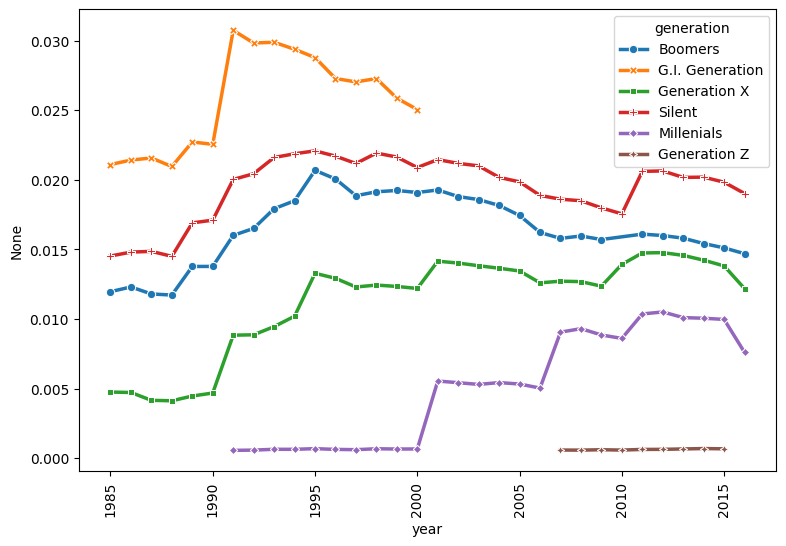

In [66]:
# Agrupar por Ano e Faixa Etária
df_generation = df.groupby(["year", "generation"])[["suicides_no", "population"]].sum()

# Resetar o índice
df_reset = df_generation.reset_index()

# Criar o gráfico
plt.figure(figsize=(9, 6))
sns.lineplot(
    x="year", 
    y=df_reset["suicides_no"] * 100 / df_reset["population"], 
    hue="generation",
    data=df_reset, 
    linewidth=2.5, 
    style="generation", 
    markers=True, 
    dashes=False
)
plt.xticks(rotation=90)
plt.show()



### Análise por País e Continente

- Verificando quantidade de países no dataset

In [67]:
df_agrupado_pais = df.groupby("country")["suicides_no"].sum()
country_name = list(df_agrupado_pais.index.get_level_values(0))
len(country_name)

101

- Mapeamento dos nomes dos países para seus códigos

In [68]:
# Mapeando Nome de País para Código do País
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3


# Verificando se tem algum país fora do mapeamento
country_not_in_list = [i for i in country_name[:] if i not in countries.keys()]
country_not_in_list

['Czech Republic',
 'Macau',
 'Republic of Korea',
 'Saint Vincent and Grenadines',
 'Turkey']

- Renomeando os países fora da lista

In [69]:
df.replace("Republic of Korea", "Korea, Republic of", inplace = True)
df.replace('Czech Republic', "Czechia", inplace = True)
df.replace('Macau', 'Macao', inplace = True)
df.replace('Saint Vincent and Grenadines', "Saint Vincent and the Grenadines", inplace = True)

- Calculando a média da taxa de suícídio

In [70]:
# 
df_suicides_no= df.groupby(["country","year"])["suicides_no"].sum()
df_sum = df_suicides_no.sort_index(ascending=True)[:] * 100

# População total por país e ano
df_population = df.groupby(["country","year"])["population"].sum()
df_population_sum = df_population.sort_index(ascending=False)[:]

# Taxa de suicídio
df_total = df_sum / df_population_sum
df_total.head(10)

country  year
Albania  1987    0.002694
         1988    0.002279
         1989    0.002426
         1992    0.001665
         1993    0.002600
         1994    0.001755
         1995    0.003031
         1996    0.003027
         1997    0.005710
         1998    0.005112
dtype: float64

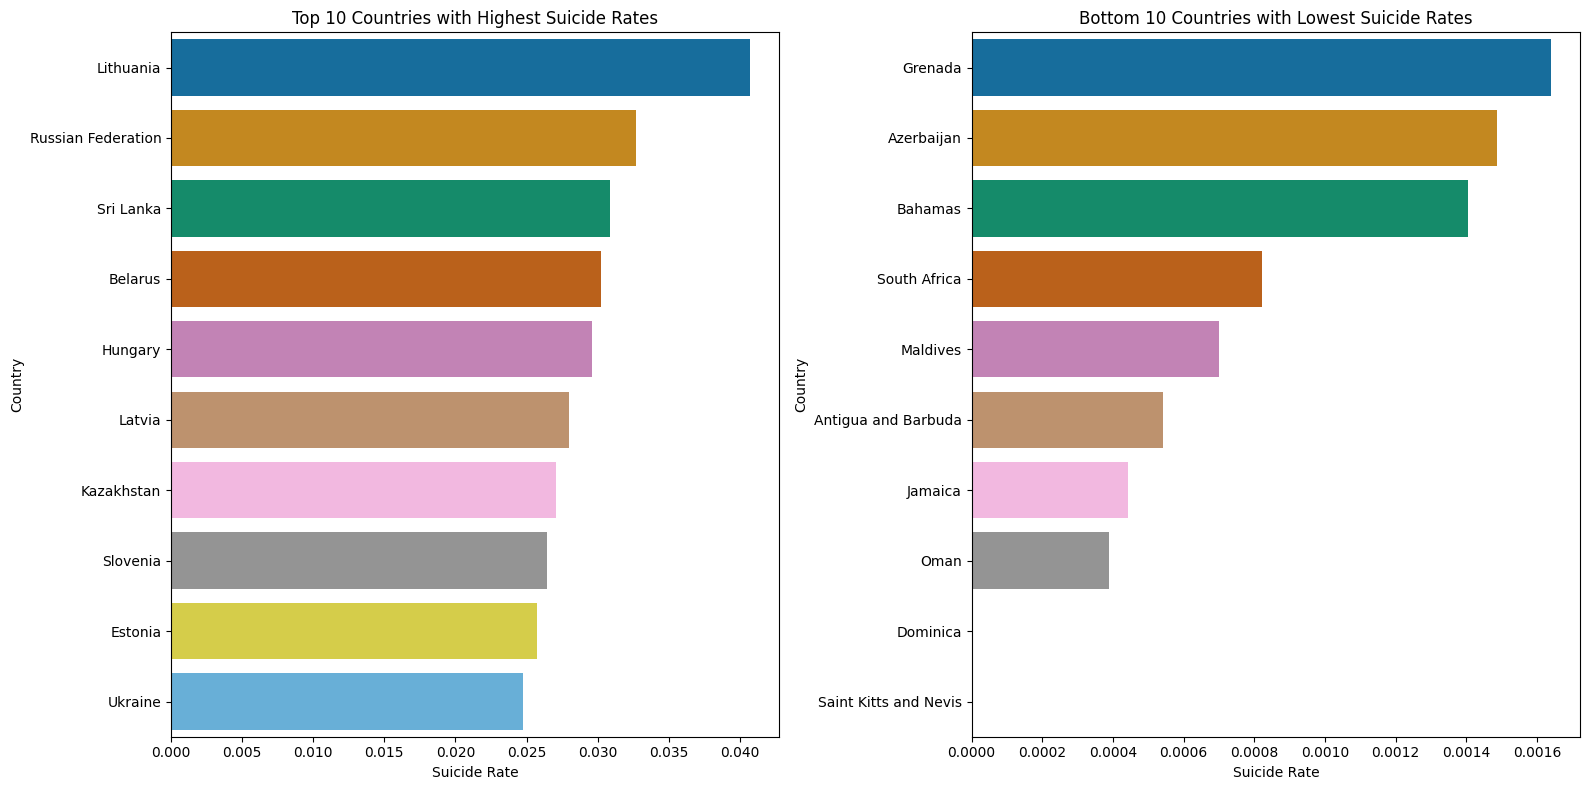

In [71]:
country_dict={}

# Iterar sobre os países
for country in df_total.index.get_level_values(0):
    if country not in country_dict.keys(): # Verifica se o país está no dicionário
        country_dict[country] = df_total[country].mean() # Se não estiver, calcula a taxa média de suicídios e adicionar no dicionário
    else:
        pass

# Converter o dict em tupla e ordena
tup = list(country_dict.items())
tup.sort(key= lambda pair:pair[1], reverse = True)

# Separando a lista ordenada em duas listas: de nomes dos paises e suicidos
country_list = [a[0] for a in tup]
country_suicide = [a[1] for a in tup]

# Selecione os top 10 e bottom 10 países
top_10 = country_list[:10]
top_10_suicides = country_suicide[:10]
bottom_10 = country_list[-10:]
bottom_10_suicides = country_suicide[-10:]

# Plotando os gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Gráfico para os Top 10 países
sns.barplot(x=top_10_suicides, y=top_10, palette="colorblind", ax=axes[0])
axes[0].set_title("Top 10 Countries with Highest Suicide Rates")
axes[0].set_xlabel("Suicide Rate")
axes[0].set_ylabel("Country")

# Gráfico para os Bottom 10 países
sns.barplot(x=bottom_10_suicides, y=bottom_10, palette="colorblind", ax=axes[1])
axes[1].set_title("Bottom 10 Countries with Lowest Suicide Rates")
axes[1].set_xlabel("Suicide Rate")
axes[1].set_ylabel("Country")

plt.tight_layout()
plt.show()

- Substituindo as chaves do dicionário pelo código alpha3

In [72]:
# Mapeando Nome de País para Código do País
countries = {country.name: country.alpha_3 for country in pycountry.countries}

# Verificando se há países fora do mapeamento
country_not_in_list = [name for name in country_dict.keys() if name not in countries]
print("Countries not in mapping:", country_not_in_list)

# Criando o dicionário para armazenar os códigos ISO e as taxas de suicídio
new_country_dict = {"iso_a3": [], "suicide_rate": []}

# Iterando sobre o dicionário de taxas de suicídio
for country_name, suicide_rate in country_dict.items():
    if country_name in countries:
        iso_code = countries[country_name]  # Obter o código ISO
        new_country_dict["iso_a3"].append(iso_code)
        new_country_dict["suicide_rate"].append(suicide_rate)

# Criando um DataFrame com os dados
new_country_df = pd.DataFrame(new_country_dict)

# Visualizando o DataFrame resultante
print(new_country_df.head())

Countries not in mapping: ['Turkey']
  iso_a3  suicide_rate
0    ALB      0.003137
1    ATG      0.000541
2    ARG      0.007911
3    ARM      0.002475
4    ABW      0.008097



### Geolocalicação

In [73]:
# Substitua pelo caminho correto para o arquivo shapefile em seu computador
shapefile_path = "./geopandas_files/ne_110m_admin_0_countries.shp"

# Carregar o shapefile
world = gpd.read_file(shapefile_path)

# Exibir as primeiras linhas
world.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,None,None,Unrecognized,None,None,None,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."


In [74]:
# Realize o merge com a coluna correta
result = pd.merge(world, new_country_df, left_on="SOV_A3", right_on="iso_a3")

# Visualizar as primeiras linhas do DataFrame resultante
result.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,iso_a3,suicide_rate
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ...",FJI,0.003708
1,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025...",CAN,0.013131
2,Admin-0 country,1,3,Uzbekistan,UZB,0,2,Sovereign country,1,Uzbekistan,...,None,None,None,None,None,None,None,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",UZB,0.007232
3,Admin-0 country,1,2,Argentina,ARG,0,2,Sovereign country,1,Argentina,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25 -5...",ARG,0.007911
4,Admin-0 country,1,2,Chile,CHL,0,2,Sovereign country,1,Chile,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...",CHL,0.009249


<Axes: title={'center': 'world suicide rate'}>

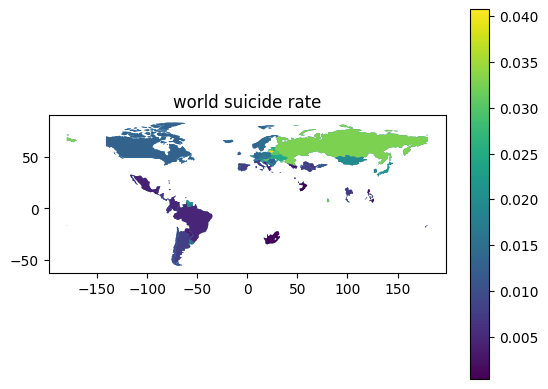

In [75]:
ax = result.plot()
ax.set_title("world suicide rate")
result.plot(column='suicide_rate', ax = ax, legend=True)

- Criar Coluna Continente

In [85]:
df.head(1)

,country,year,sex,age,suicides_no,population,suicides_pop,HDI_for_year,gdp_for_year,gdp_per_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,NaN,2156624900,796,Generation X


In [94]:
# Mapeamento de países para continentes
country_to_continent = dict(zip(world['SOVEREIGNT'], world['REGION_WB']))

# Supondo que seu DataFrame original seja `df_total` e tenha a coluna 'country'
df['continent'] = df['country'].map(lambda x: country_to_continent.get(x, 'Unknown'))

# Visualizar o DataFrame com o continente
df['continent'].value_counts(dropna=False)

continent
Europe & Central Asia         12362
Latin America & Caribbean      6060
Unknown                        5624
East Asia & Pacific            2096
Middle East & North Africa      958
North America                   348
Sub-Saharan Africa              240
South Asia                      132
Name: count, dtype: int64

In [103]:
# Visualizar o DataFrame com o continente
df['continent'].value_counts(dropna=False)

continent
Europe & Central Asia         12362
Latin America & Caribbean      6060
North America                  3154
East Asia & Pacific            2096
Asia                           1128
Middle East & North Africa      958
Europe                          948
Africa                          610
Sub-Saharan Africa              240
Oceania                         132
South Asia                      132
Name: count, dtype: int64

- Preenchendo os continentes restantes

In [ ]:
# Mapeamento manual dos países com 'Unknown' para seus respectivos continentes
manual_continent_mapping = {
    'Mauritius': 'Africa',
    'Korea, Republic of': 'Asia',
    'Singapore': 'Asia',
    'Puerto Rico': 'North America',
    'Malta': 'Europe',
    'United States': 'North America',
    'Saint Lucia': 'North America',
    'Antigua and Barbuda': 'North America',
    'Russian Federation': 'Europe',
    'Grenada': 'North America',
    'Saint Vincent and the Grenadines': 'North America',
    'Barbados': 'North America',
    'Bahamas': 'North America',
    'Bahrain': 'Asia',
    'Serbia': 'Europe',
    'Seychelles': 'Africa',
    'Aruba': 'North America',
    'Kiribati': 'Oceania',
    'Maldives': 'Asia',
    'San Marino': 'Europe',
    'Saint Kitts and Nevis': 'North America',
    'Cabo Verde': 'Africa',
    'Dominica': 'North America',
    'Macao': 'Asia'
}

# Filtrar países que têm 'Unknown' no continente
unknown_countries = df[df['continent'] == 'Unknown']['country']

# Preencher apenas os países com continente 'Unknown'
for country in unknown_countries:
    if country in manual_continent_mapping:
        df.loc[df['country'] == country, 'continent'] = manual_continent_mapping[country]


Empty DataFrame
Columns: [country, year, sex, age, suicides_no, population, suicides_pop, HDI_for_year, gdp_for_year, gdp_per_capita, generation, continent]
Index: []


In [104]:
# Dicionário para mapear continentes menores para continentes maiores
continent_mapping = {
    'Europe & Central Asia': 'Europe',
    'Latin America & Caribbean': 'Latin America',
    'North America': 'North America',
    'East Asia & Pacific': 'Asia',
    'Asia': 'Asia',
    'Middle East & North Africa': 'Middle East & North Africa',
    'Europe': 'Europe',
    'Africa': 'Africa',
    'Sub-Saharan Africa': 'Africa',
    'Oceania': 'Oceania',
    'South Asia': 'Asia'
}

# Aplicando o mapeamento para substituir os valores de continente no DataFrame
df['continent'] = df['continent'].map(continent_mapping).fillna(df['continent'])

# Verificando o resultado
df['continent'].value_counts()


continent
Europe                        13310
Latin America                  6060
Asia                           3356
North America                  3154
Middle East & North Africa      958
Africa                          850
Oceania                         132
Name: count, dtype: int64


## Modelagem

In [105]:
dataset = df.copy()
dataset = dataset.drop(columns=['country']) 

In [106]:
dataset.columns

Index(['year', 'sex', 'age', 'suicides_no', 'population', 'suicides_pop',
       'HDI_for_year', 'gdp_for_year', 'gdp_per_capita', 'generation',
       'continent'],
      dtype='object')

In [107]:
dataset['HDI_for_year'].fillna(dataset['HDI_for_year'].mean(),inplace=True)


### K-Means

In [108]:
# 2. Selecionar colunas numéricas e categóricas
numerical_columns = dataset.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = dataset.select_dtypes(include=['object']).columns

# 3. Definindo o pré-processamento para as colunas
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numerical_columns),
                  ('cat', OneHotEncoder(sparse_output=False), categorical_columns)])  # Removendo a esparsidade

# 4. Construindo o pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('kmeans', KMeans(n_clusters=3, random_state=42))])

# 5. Separando os dados para treinamento
X = dataset  

# 6. Treinando o pipeline
pipeline.fit(X)

# 7. Atribuindo os clusters ao dataframe
dataset['Cluster'] = pipeline.predict(X)

# Verificando os resultados
print(dataset[['Cluster']].head())

   Cluster
0        2
1        2
2        2
3        2
4        2


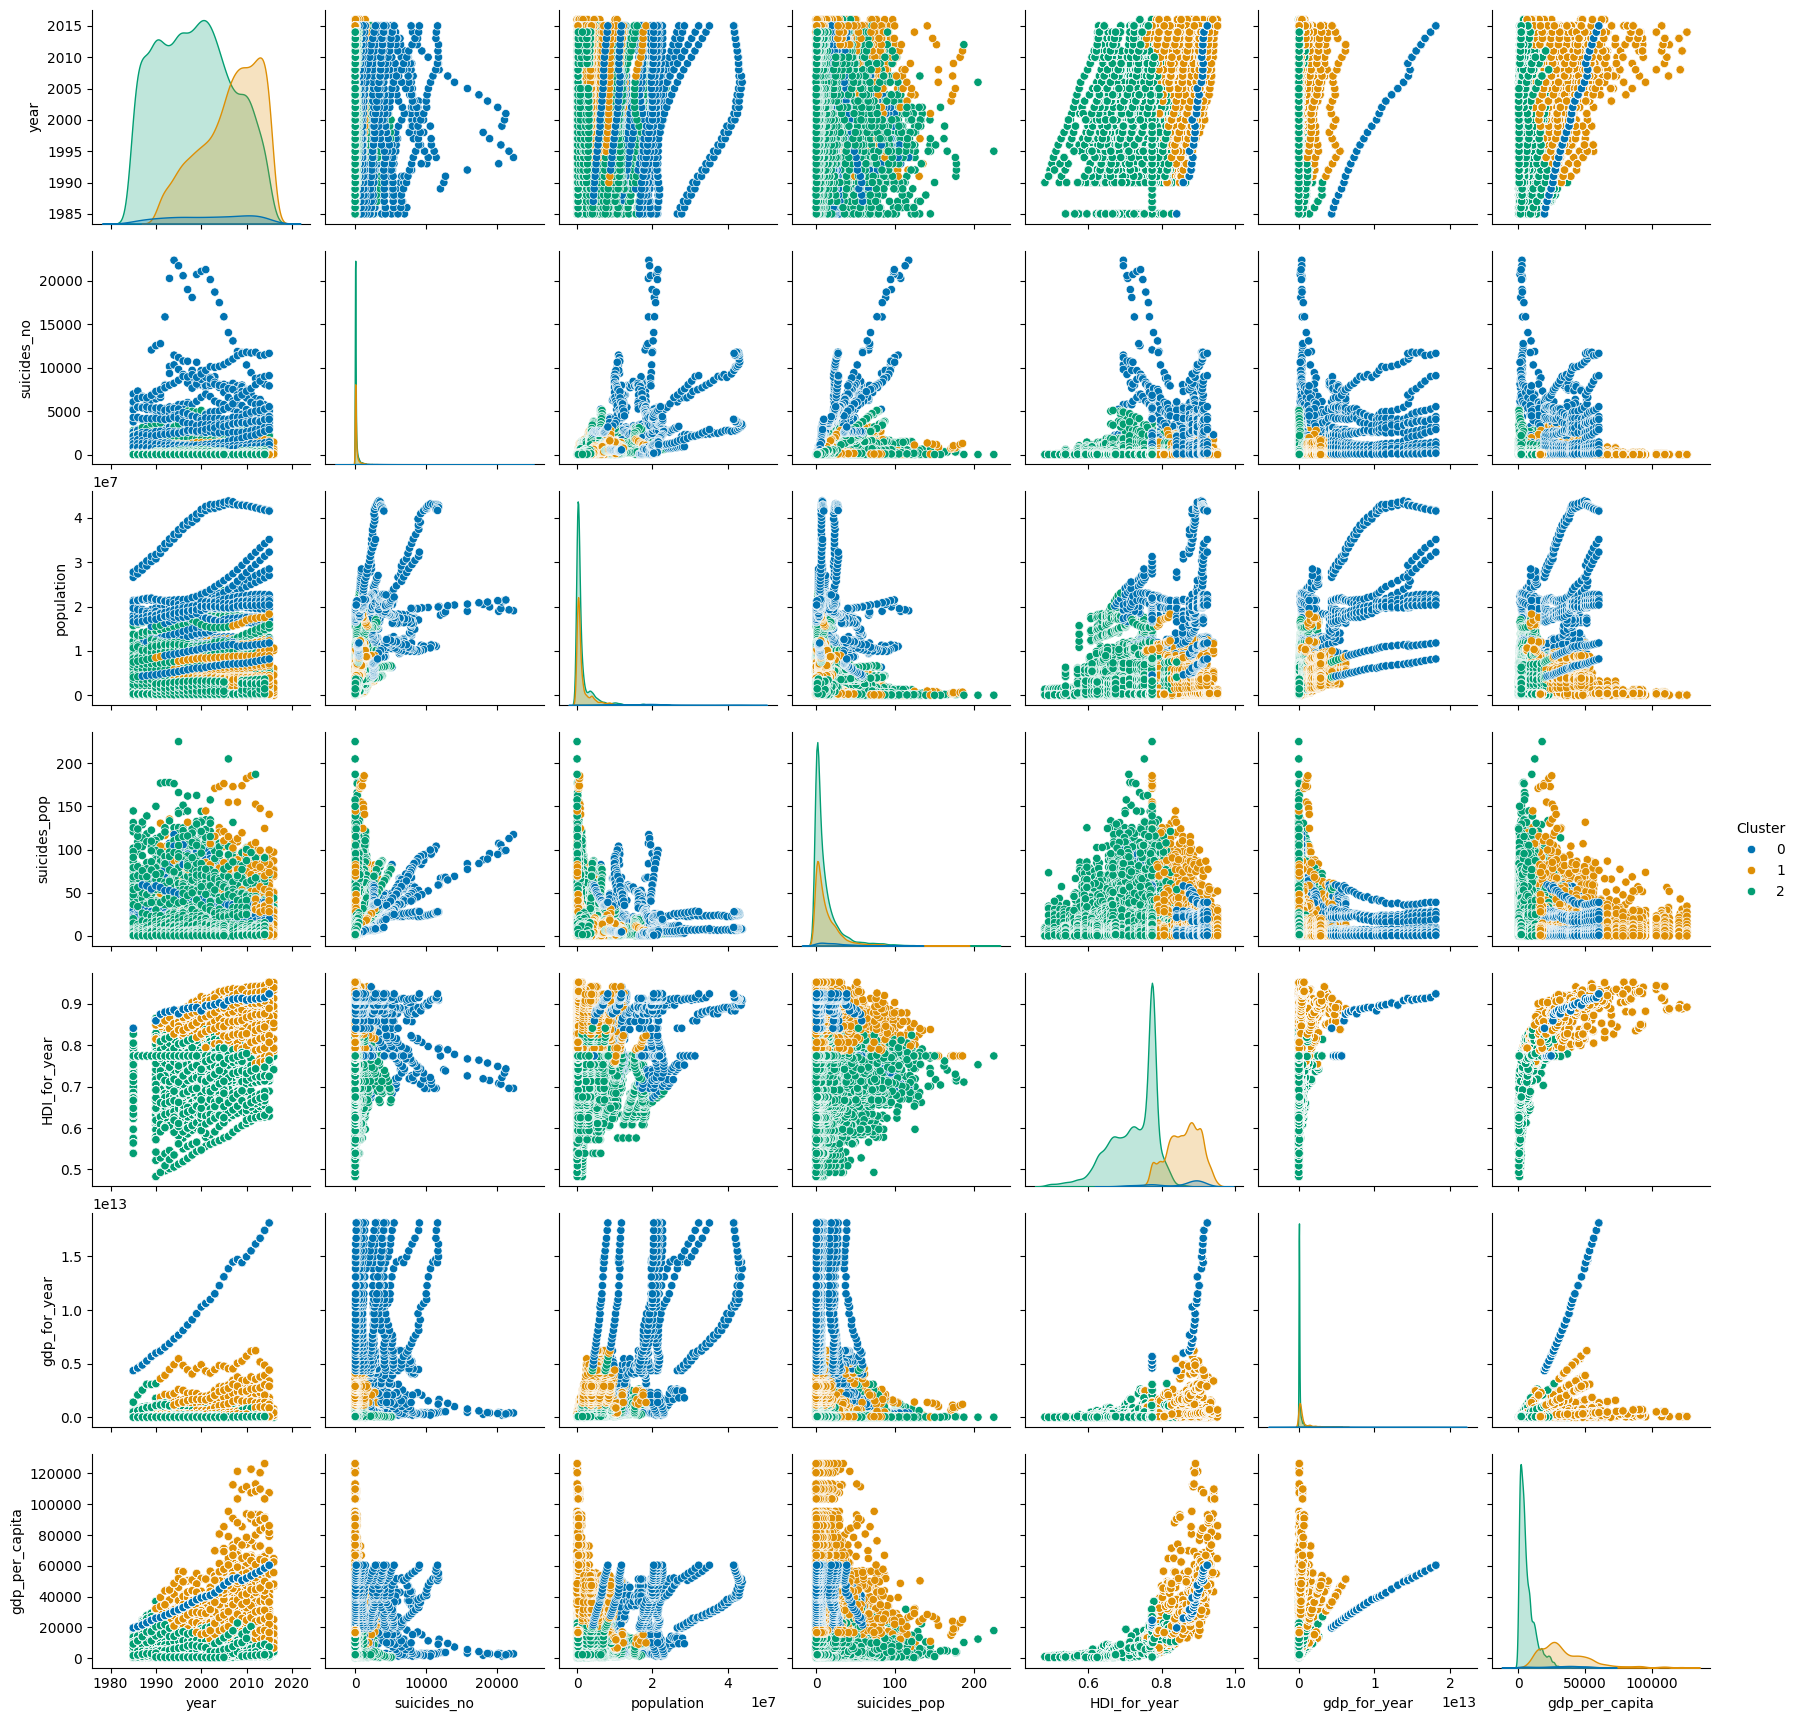

In [110]:
sns.pairplot(data = dataset, hue = "Cluster", palette="colorblind")

- Não é possível identificar bem classes separadas


## DBSCAN